In [8]:
import rasterio
from rasterio.features import shapes
from rasterio.mask import mask
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from shapely.geometry import box
import geopandas as gpd
from shapely.geometry import shape, Polygon, MultiPolygon


# Directory paths
test_images_dir = '../data/test_downscaled/cat'
predicted_masks_dir = '../data/test_masks_tif/cat'
output_dir = '../data/test_polygons/cat'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

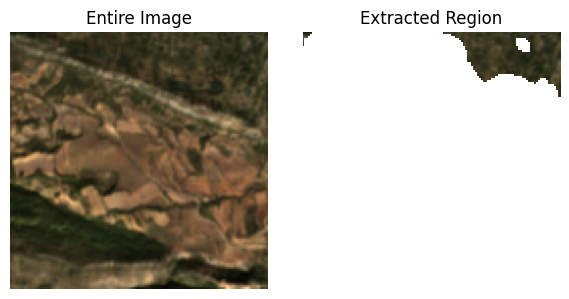

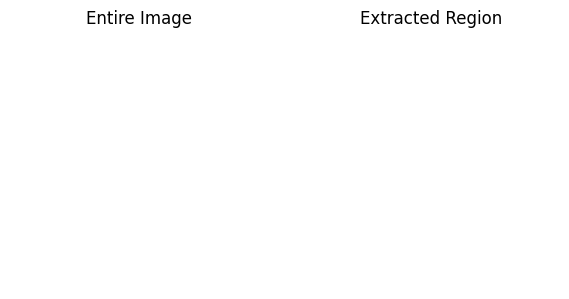

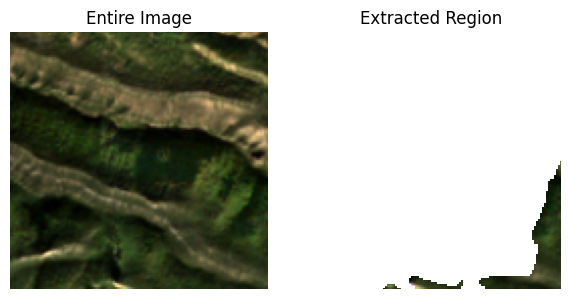

In [9]:
# Function to load the first mask and corresponding test image
def load_mask_and_image(mask_path, image_path):
    # Load the binary mask
    binary_mask = np.load(mask_path)

    # Load the test image
    with rasterio.open(image_path) as src:
        red = src.read(1)  # Band 1 corresponds to B4
        green = src.read(2)  # Band 2 corresponds to B3
        blue = src.read(3)  # Band 3 corresponds to B2
        
        # Stack the R, G, B arrays into a single three-dimensional array
        rgb_image = np.stack((red, green, blue), axis=-1)
        rgb_image = rgb_image.astype('float')
        rgb_image /= rgb_image.max()
        
        meta = src.meta

    return binary_mask, rgb_image, meta

# Function to plot the entire image and the extracted region
def plot_image_and_extracted_region(binary_mask, rgb_image, output_dir, image_name, meta):
    # Extract the region where the mask values are True
    extracted_region = np.where(binary_mask[:, :, None], rgb_image, np.nan)

    # Plot the entire image
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title('Entire Image')
    plt.axis('off')

    # Plot the extracted region
    plt.subplot(1, 2, 2)
    plt.imshow(extracted_region)
    plt.title('Extracted Region')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get the list of mask and image files
mask_files = sorted([f for f in os.listdir(predicted_masks_dir) if f.endswith('.npy')])
image_files = sorted([f for f in os.listdir(test_images_dir) if f.endswith('.tif')])

# Plot the first 10 images and their extracted regions
for i in [-1, -2, -3]:
    mask_path = os.path.join(predicted_masks_dir, mask_files[i])
    image_path = os.path.join(test_images_dir, image_files[i])
    binary_mask, rgb_image, meta = load_mask_and_image(mask_path, image_path)
    plot_image_and_extracted_region(binary_mask, rgb_image, output_dir, image_files[i], meta)

Exported multipolygon to ../data/test_polygons/cat/mask_0_multipolygon.geojson
Exported multipolygon to ../data/test_polygons/cat/mask_1_multipolygon.geojson
Exported multipolygon to ../data/test_polygons/cat/mask_2_multipolygon.geojson
Exported multipolygon to ../data/test_polygons/cat/mask_3_multipolygon.geojson
Exported multipolygon to ../data/test_polygons/cat/mask_4_multipolygon.geojson
Exported multipolygon to ../data/test_polygons/cat/mask_5_multipolygon.geojson
Exported multipolygon to ../data/test_polygons/cat/mask_6_multipolygon.geojson
Exported multipolygon to ../data/test_polygons/cat/mask_7_multipolygon.geojson
Exported multipolygon to ../data/test_polygons/cat/mask_8_multipolygon.geojson
Exported multipolygon to ../data/test_polygons/cat/mask_9_multipolygon.geojson
Exported multipolygon to ../data/test_polygons/cat/mask_10_multipolygon.geojson
Exported multipolygon to ../data/test_polygons/cat/mask_11_multipolygon.geojson
Exported multipolygon to ../data/test_polygons/cat

/Users/jonaswallstein/Library/CloudStorage/GoogleDrive-jonas.wallstein@bse.eu/Meine Ablage/github_drive/dl_final_project/.adl_project_venv/lib/python3.12/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
/Users/jonaswallstein/Library/CloudStorage/GoogleDrive-jonas.wallstein@bse.eu/Meine Ablage/github_drive/dl_final_project/.adl_project_venv/lib/python3.12/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
/Users/jonaswallstein/Library/CloudStorage/GoogleDrive-jonas.wallstein@bse.eu/Meine Ablage/github_drive/dl_final_project/.adl_project_venv/lib/python3.12/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Noth

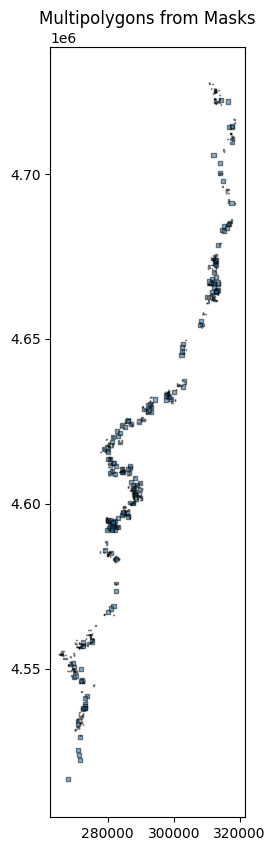

In [13]:
# Function to convert binary mask to multipolygon
def mask_to_multipolygon(mask, transform):
    mask = mask.astype(np.uint8)
    mask[mask == 0] = 0  # Background
    mask[mask == 1] = 1  # Foreground

    # Extract shapes from the mask
    shapes_generator = shapes(mask, transform=transform)
    
    polygons = []
    for geom, value in shapes_generator:
        if value == 1:
            polygons.append(shape(geom))
    
    # Combine all polygons into a multipolygon
    multipolygon = MultiPolygon(polygons)
    return multipolygon

# Load masks and images, convert to multipolygons, and save
multipolygons = []
for i in range(len(mask_files)):
    mask_path = os.path.join(predicted_masks_dir, mask_files[i])
    image_path = os.path.join(test_images_dir, image_files[i])
    
    binary_mask, image_data, meta, bounds, crs = load_mask_and_image(mask_path, image_path)
    
    # Convert binary mask to multipolygon
    multipolygon = mask_to_multipolygon(binary_mask, meta['transform'])
    multipolygons.append(multipolygon)
    
    # Create a GeoDataFrame and save to GeoJSON
    gdf = gpd.GeoDataFrame({'geometry': [multipolygon]}, crs=crs)
    output_geojson_path = os.path.join(output_dir, f'mask_{i}_multipolygon.geojson')
    gdf.to_file(output_geojson_path, driver='GeoJSON')
    
    print(f"Exported multipolygon to {output_geojson_path}")

# Plot the multipolygons
fig, ax = plt.subplots(figsize=(10, 10))
for i, multipolygon in enumerate(multipolygons):
    gdf = gpd.GeoDataFrame({'geometry': [multipolygon]}, crs=crs)
    gdf.plot(ax=ax, edgecolor='k', alpha=0.5)
plt.title('Multipolygons from Masks')
plt.show()